<a href="https://colab.research.google.com/github/dajiro-repo/blog/blob/master/blog_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  81190      0 --:--:-- --:--:-- --:--:-- 81190
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
Uninstalling torch-1.5.1+cu101:
     |████████████████████████████████| 61kB 516kB/s 
ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_vendor/pkg_resources/__init__

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.models as models
import torch_xla
import torch_xla.core.xla_model as xm

In [3]:
###############
# 入力パラメータ
###############
#モデル名
model_name = 'resnet'
#画像のパス
image_path = './imagenetv2-matched-frequency-format-val/'
#バッチサイズ
batch_size = 32
#エポック数
epochs = 5
#GPUID
ngpu = 1
#ラベル数
n_class = 1000
#画像サイズ
image_size = 224
#ワーカー数
workers = 1
#訓練用データ比率
train_ratio = 0.7
#検証用データ比率
val_ratio = 0.2
#学習率
lr = 0.00001
#Adamのbeta1
beta1 = 0.9
#チャネル数
nc = 3
#中間層チャネル数のユニット
ndf = 16
device = xm.xla_device()
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

xla:1


In [4]:
if not os.path.exists('./imagenetv2-matched-frequency-format-val/'):
    !curl -s https://s3-us-west-2.amazonaws.com/imagenetv2public/imagenetv2-matched-frequency.tar.gz | tar x
# dataset = Dataset('./imagenetv2-matched-frequency-format-val/')
# for i in range(len(dataset)): # warmup
#     dummy = dataset[i]

In [5]:
def get_data_loaders(batch_size, train_ratio, val_ratio):
    dataset = dset.ImageFolder(root=image_path,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225]),
                               ]))

    num_data = len(dataset)
    num_list = [int(train_ratio * num_data),
                int(val_ratio * num_data),
                num_data -
                int(train_ratio * num_data) -
                int(val_ratio * num_data)]
    collate_fn = None
    train_data, val_data, test_data = utils.data.random_split(dataset,
                                                              [num_list[0],
                                                               num_list[1],
                                                               num_list[2]])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             shuffle=True, num_workers=workers,
                                             collate_fn = collate_fn)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                             shuffle=True, num_workers=workers,
                                             collate_fn = collate_fn)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                             shuffle=True, num_workers=workers,
                                             collate_fn = collate_fn)
    
    return train_loader, val_loader, test_loader

In [6]:
class WResNet(nn.Module):
    def __init__(self, n_out):
        super(WResNet, self).__init__()
        self.resnet = models.wide_resnet50_2(pretrained=True)
        self.resnet.fc = nn.Linear(2048, n_out)

    def forward(self, x):
        return self.resnet(x)

In [45]:
#モデル
model = WResNet(n_class)
#model = xm.send_cpu_data_to_device(model, device)
# params_to_update = []
# update_param_names = ["resnet.fc.weight", "resnet.fc.bias"]
# for name, param in model.named_parameters():
#     if name in update_param_names:
#       param.requires_grad = True
#       params_to_update.append(name)
#     else:
#       param.requires_grad = False

In [46]:
# 損失関数（closs entropy）
criterion = nn.CrossEntropyLoss()
#Optimizer(Adamを使用)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

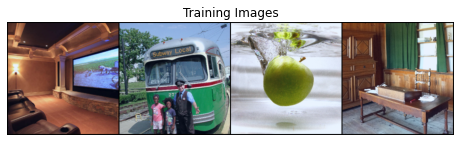

In [47]:
train_loader, val_loader, test_loader = get_data_loaders(batch_size,
                                                         train_ratio,
                                                         val_ratio)
dataloaders_dict = {"train":train_loader, "val":val_loader}

real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:4], padding=2, normalize=True).cpu(),(1,2,0)))

In [48]:
%%time
accuracy, accuracy_val = [], []
model.to(device)
for epoch in range(epochs):
    for phase in ["train", "val"]:
        if phase == "train":
          model.train()
        else:
          model.eval()

        loss_epoch = 0.0
        acc_epoch = 0.0

        if (epoch == 0) and (phase == "train"):
            continue

        for inputs, labels in dataloaders_dict[phase]:
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == "train"):
                labels = labels.to(device)
                inputs = inputs.to(device)
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                if phase == "train":
                    loss.backward()
                    #optimizer.step()
                    xm.optimizer_step(optimizer, barrier=True)
                
                loss_epoch += loss.item() * inputs.size(0)
                acc_epoch += torch.sum(preds == labels.data)
        
        loss_epoch = loss_epoch / len(dataloaders_dict[phase].dataset)
        acc_epoch = acc_epoch.double() / len(dataloaders_dict[phase].dataset)
        print(f"phase: {phase}",
              f"epoch: {epoch}",
              f"loss: {loss_epoch:.4f}",
              f"accuracy: {acc_epoch:.4f}")

print('Finished Training')

phase: val epoch: 0 loss: 6.9609 accuracy: 0.0010
phase: train epoch: 1 loss: 6.9581 accuracy: 0.0004
phase: val epoch: 1 loss: 6.9582 accuracy: 0.0010
phase: train epoch: 2 loss: 6.9582 accuracy: 0.0006
phase: val epoch: 2 loss: 6.9589 accuracy: 0.0010
phase: train epoch: 3 loss: 6.9552 accuracy: 0.0003
phase: val epoch: 3 loss: 6.9578 accuracy: 0.0005
phase: train epoch: 4 loss: 6.9558 accuracy: 0.0010
phase: val epoch: 4 loss: 6.9599 accuracy: 0.0000
Finished Training
CPU times: user 1min 13s, sys: 23 s, total: 1min 36s
Wall time: 8min 31s


In [ ]:
"""
TPU(全パラ):7min 58sec, 12min 35s, 8min 31s
TPU(最終層のみ):7min 8sec

GPU(全パラ):11min 15sec, 11min 8sec
"""

Text(0, 0.5, 'minutes')

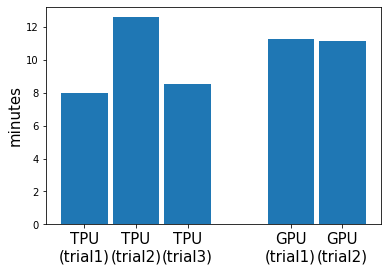

In [50]:
TPU1=(7*60+58)/60
TPU2=(12*60+35)/60
TPU3=(8*60+31)/60
GPU1=(11*60+15)/60
GPU2=(11*60+8)/60
fontsize = 15
plt.bar([0.75, 1.25, 1.75, 2.75, 3.25], [TPU1, TPU2, TPU3, GPU1, GPU2], width=0.45)
plt.xticks(ticks=[0.75, 1.25, 1.75, 2.75, 3.25], labels=["TPU\n(trial1)", "TPU\n(trial2)", "TPU\n(trial3)", "GPU\n(trial1)", "GPU\n(trial2)"], fontsize=fontsize)
plt.ylabel("minutes", fontsize=fontsize)